In [26]:
# pip install fredapi pandas numpy statsmodels
import os
import numpy as np
import pandas as pd
from fredapi import Fred
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import seaborn as sns
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller


## Pipeline to prepare data, check cointegration, fit VECM and fit VAR in levels to derive IRFs

In [2]:

# ── 0) FRED API key ─────────────────────────────────────────────────────────────

fred = Fred(api_key="6778de290574049191b08f6b46e3943e")


In [3]:

# ── 1) Pull series ─────────────────────────────────────────────────────────────
# Real GDP, quarterly; CPI, monthly
gdp = fred.get_series("GDPC1")      # Real GDP, quarterly
cpi = fred.get_series("CPIAUCSL")   # CPI, monthly

# Convert to DataFrames with nice column names
gdp = gdp.to_frame(name="gdp")      # index: DatetimeIndex (quarter end)
cpi = cpi.to_frame(name="cpi")      # index: DatetimeIndex (month end)



In [ ]:
# ── 2) Make variables quarterly ──────────────────────────────────────────────────────

cpi_q = cpi.resample("Q-DEC").last()
cpi_q.index = cpi_q.index.to_period("Q-DEC")

# GDP is already quarterly, so force same frequency
gdp_q = gdp.copy()
gdp_q.index = gdp_q.index.to_period("Q-DEC")


# ── 3) Merge to one quarterly DataFrame & take logs ────────────────────────────
df_q = pd.concat([gdp_q, cpi_q, df_ex], axis=1).dropna()    # inner join on common quarters
macro_levels = np.log(df_q).rename(columns={"gdp": "log_gdp", "cpi": "log_cpi"})


/tmp/ipykernel_16975/2654948868.py:3: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  cpi_q = cpi.resample("Q-DEC").last()


In [5]:
print(df_q.head())
print(df_q.columns)        
print(macro_levels.head())
macro_levels.info()

             gdp    cpi
1947Q1  2182.681  22.00
1947Q2  2176.892  22.08
1947Q3  2172.432  22.84
1947Q4  2206.452  23.41
1948Q1  2239.682  23.50
Index(['gdp', 'cpi'], dtype='object')
         log_gdp   log_cpi
1947Q1  7.688309  3.091042
1947Q2  7.685653  3.094672
1947Q3  7.683603  3.128513
1947Q4  7.699141  3.153163
1948Q1  7.714089  3.157000
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 314 entries, 1947Q1 to 2025Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   log_gdp  314 non-null    float64
 1   log_cpi  314 non-null    float64
dtypes: float64(2)
memory usage: 7.4 KB


In [27]:

# ── 4) Unit-root checks (expect non-stationary logs)
for col in ["log_gdp", "log_cpi"]:
    pval = adfuller(macro_levels[col])[1]
    print(f"ADF p-value for {col}: {pval:.3f}")


ADF p-value for log_gdp: 0.169
ADF p-value for log_cpi: 0.937


In [ ]:

# ── 5) Choose VAR lag order up to 8  and keep the AIC (or BIC) winner
sel = VAR(macro_levels).select_order(8)
p = sel.selected_orders["aic"]  # or "bic"
print("Selected VAR lag (AIC):", p)

# ── 6) Johansen cointegration test (ecdet='const', K=2) ─
# det_order=0  => constant restricted to the cointegration relation ("const")
# k_ar_diff = K-1 (R's K=2 => 1)
jres = coint_johansen(macro_levels, det_order=0, k_ar_diff=1)

# Trace statistics and critical values
print("Trace statistics:", jres.lr1)      # array of trace stats
print("Critical values (90/95/99%):\n", jres.cvt)  # rows per rank, cols per quantile

# Helper: infer rank at 95%
alpha_col = 1  # 0=90%, 1=95%, 2=99%
rank = 0
for i, stat in enumerate(jres.lr1):
    cv = jres.cvt[i, alpha_col]
    print(f"Trace stat (r<={i}): {stat:.4f}  |  95% cv: {cv:.4f}")
    if stat > cv:
        rank = i + 1
    else:
        break

print("Inferred cointegration rank @95%:", rank)



# ── 7) Fit the appropriate model ──────────
if rank == 0:
 #  Convert to stationary series via first differences (log growth rates)
    macro_diff = macro_levels.diff().dropna()
    macro_diff.columns = [c.replace("log_", "") + "_g" for c in macro_diff.columns]  # e.g. "gdp_g" = growth

 # Confirm stationarity of diffs (ADF)
    for col in macro_diff.columns:
        pval = adfuller(macro_diff[col])[1]
        print(f"ADF (diff) p-value for {col}: {pval:.3f}")

# Select VAR lag order for the differenced series
    sel_diff = VAR(macro_diff).select_order(8)
    p_diff = sel_diff.selected_orders["aic"] or sel_diff.selected_orders["bic"] or 1
    print("Selected VAR lag on diffs (AIC):", p_diff)

# Fit VAR on differences
    var_diff = VAR(macro_diff).fit(p_diff, trend="c")
    print(var_diff.summary())



Selected VAR lag (AIC): 4
Trace statistics: [9.95849448 4.35728227]
Critical values (90/95/99%):
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Trace stat (r<=0): 9.9585  |  95% cv: 15.4943
Inferred cointegration rank @95%: 0
ADF (diff) p-value for gdp_g: 0.000
ADF (diff) p-value for cpi_g: 0.000
Selected VAR lag on diffs (AIC): 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Oct, 2025
Time:                     17:21:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.9739
Nobs:                     310.000    HQIC:                  -19.0752
Log likelihood:           2101.37    FPE:                4.85809e-09
AIC:                     -19.1426    Det(Omega_mle):     4.64590e-09
--------------------------------------------------------------------
Results for equation gdp_g
              coefficient       std. error

In [ ]:
# 3) VAR in levels for IRF/FEVD (R: vec2var). Use p=K=2 lags 
var = VAR(macro_levels).fit(maxlags=4, ic=None, trend='c')  
print(var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Oct, 2025
Time:                     16:19:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.7281
Nobs:                     306.000    HQIC:                  -18.9763
Log likelihood:           2094.30    FPE:                4.86324e-09
AIC:                     -19.1418    Det(Omega_mle):     4.36479e-09
--------------------------------------------------------------------
Results for equation log_gdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.040903         0.030465            1.343           0.179
L1.log_gdp         1.064683         0.059665           17.844           0.000
L1.log_cpi         0.083761         0.104241            0.804         

## Interpretations: VAR on first differences- Diagnostic Summary

- Cointegration / stationarity
  - Johansen: inferred rank = 0 → no cointegration between log_gdp and log_cpi.
  - ADF on first differences: p ≈ 0.000 for both series → diffs are stationary. Using a VAR on growth (first differences) is appropriate for short‑run dynamics.

#### GDP Equation
+ GDP depends strongly on its own recent past.
+ Higher-order GDP lags (L2–L4) are small/insignificant → diminishing influence beyond one quarter.
+ CPI lags mostly insignificant → inflation shocks don’t meaningfully drive GDP in short run.
✅ GDP behaves like a near-AR(1/2) process: stable but persistentG.DP growth has modest short‑run autoregressive inertia.

#### CPI Equation

+ Strong inertia in CPI growth: L1.cpi ≈ 0.339 and L3.cpi ≈ 0.300 highly significant; L2.cpi ≈ 0.123 (p≈0.03) also significant → persistent inflation dynamics across multiple lags.
    + CPI shocks fade slowly, matching economic intuition (inflation inertia).

✅ Inflation properly modeled as a multi-lag(AR(4)) process with gradual mean reversion

+ ρ(log_gdp, log_cpi) = 0.163 → modest positive correlation; expected since inflation and GDP co-move slightly.



## Diagnostics on differenced VAR residuals

In [38]:

model_for_diag = var_diff  # or var if you intentionally want levels VAR diagnostics
resid_arr = getattr(model_for_diag.resid, "values", np.asarray(model_for_diag.resid))

# --- Durbin-Watson test for each residual series ---
dw_stats = durbin_watson(resid_arr)
for col, val in zip(macro_diff.columns, dw_stats):
    print(f"Durbin-Watson for {col}: {val:.2f}")

# --- Ljung-Box (Portmanteau) test for overall autocorrelation ---
for i, col in enumerate(macro_diff.columns):
    lb = acorr_ljungbox(resid_arr[:, i], lags=[12], return_df=True)
    print(f"\nLjung-Box Portmanteau test (lag 12) for {col}:")
    print(lb)



Durbin-Watson for gdp_g: 2.01
Durbin-Watson for cpi_g: 1.94

Ljung-Box Portmanteau test (lag 12) for gdp_g:
     lb_stat  lb_pvalue
12  3.748039   0.987566

Ljung-Box Portmanteau test (lag 12) for cpi_g:
      lb_stat  lb_pvalue
12  13.563824   0.329424


In [39]:
for i,col in enumerate(macro_diff.columns):
    shapiro_test = shapiro(resid_arr[:,i])
    print(col, "Shapiro-Wilk p=", shapiro_test.pvalue)


gdp_g Shapiro-Wilk p= 2.860150149257313e-18
cpi_g Shapiro-Wilk p= 1.1879294447541076e-11


## Plots of residuals

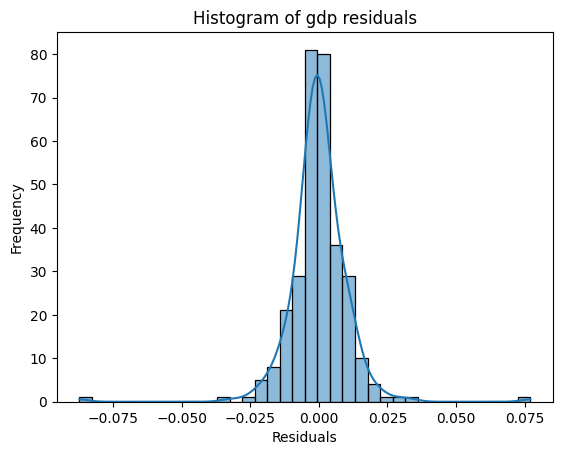

In [40]:
sns.histplot(resid_arr[:,0], kde=True)
plt.title("Histogram of gdp residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

## QQ plot

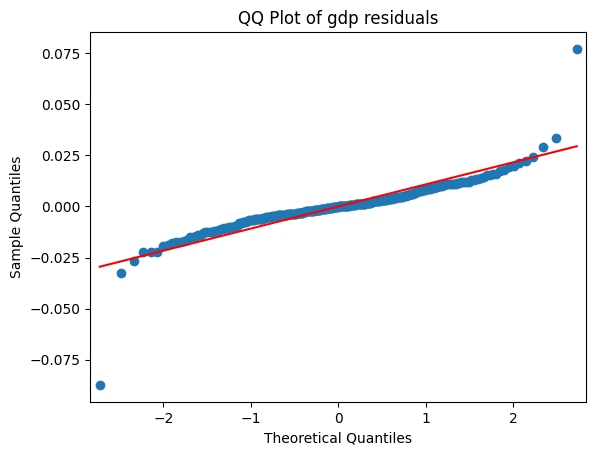

In [41]:
sm.qqplot(resid_arr[:,0], line ='s')
plt.title("QQ Plot of gdp residuals")
plt.show()

## ACFs, PACF plots of residuals

Text(0.5, 1.0, 'ACF of gdp residuals')

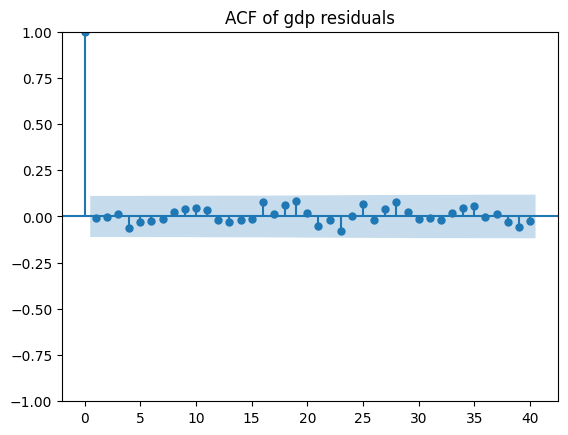

In [42]:
plot_acf(resid_arr[:,0], lags=40)
plt.title("ACF of gdp residuals")

In [44]:
#for gdp residuals

arch_test_gdp = het_arch(resid_arr[:, 0], nlags=12)
print("ARCH test for gdp - p-value:", arch_test_gdp[1])

# For cpi residuals
arch_test_cpi = het_arch(resid_arr[:, 1], nlags=12)
print("ARCH test for cpi - p-value:", arch_test_cpi[1])

ARCH test for gdp - p-value: 9.710549087172372e-17
ARCH test for cpi - p-value: 0.28193102427662875


## Interpretations from Residuals and next steps for future iterations

- Autocorrelation: Durbin–Watson and Ljung–Box indicate no remaining serial correlation in the VAR residuals (no significant autocorrelation).
- Normality: Shapiro–Wilk rejects normality (p << 0.05). Residuals display noticeable skewness and excess kurtosis (fat tails) in the histogram / QQ-plot.
- Heteroskedasticity: The ARCH test on log_gdp is significant → conditional heteroskedasticity (time-varying volatility) in the GDP equation.


Practical next steps / experiments to improve robustness
1. Bootstrap IRF/FEVD CIs
   - Use residual bootstrap to obtain empirical confidence bands for IRFs and forecasts.
2. Robust standard errors / inference
   - Where possible, compute heteroskedasticity-robust SEs for serial correlation/heteroskedasticity
3. Model conditional volatility
   - Fit VAR–GARCH / DCC–GARCH or a multivariate GARCH on residuals to model time-varying variance explicitly if volatility dynamics matter for scenarios.
4. Revisit transformations and model specification
   - Potentially test growth-rate specifications (log-differences) for short-run dynamics while keeping VECM in levels for long-run relations.
   - Add new exogenous variables (e.g., UNRATE, FEDFUNDS, consumer sentiment, nonfarm payrolls) to capture omitted drivers that may reduce residual structure.



In [ ]:
## irfs and FEVD

h = 12

if model_for_diag is globals().get('var_diff'):
    # IRFs on differences -> cumulative to map to log-levels
    irf_diff = var_diff.irf(h)
    cum_irfs = irf_diff.irfs.cumsum(axis=0)  # cumulative log-responses

    # positions in var_diff (growth) and macro_levels (log-levels)
    pos_gdp = list(macro_diff.columns).index("gdp_g")
    pos_cpi = list(macro_diff.columns).index("cpi_g")

    # cumulative responses (skip t=0)
    resp_gdp_from_cpi_level = cum_irfs[1:, pos_gdp, pos_cpi]   # cumulative change in log_gdp
    resp_cpi_from_gdp_level = cum_irfs[1:, pos_cpi, pos_gdp]   # cumulative change in log_cpi

    print("Cumulative (log-level) response GDP <- CPI (Q1..Q12):")
    print(resp_gdp_from_cpi_level.round(6))

    # FEVD on differenced VAR
    fevd = var.fevd(h)
    print(fevd.summary())


Cumulative (log-level) response GDP <- CPI (Q1..Q12):
[ 0.013929 -0.16468  -0.28321  -0.367756 -0.467707 -0.547012 -0.607806
 -0.664617 -0.711893 -0.750253 -0.783632 -0.811775]
FEVD for log_gdp
       log_gdp   log_cpi
0     1.000000  0.000000
1     0.999002  0.000998
2     0.999085  0.000915
3     0.999091  0.000909
4     0.997258  0.002742
5     0.993492  0.006508
6     0.984137  0.015863
7     0.974801  0.025199
8     0.964715  0.035285
9     0.954250  0.045750
10    0.944645  0.055355
11    0.935719  0.064281

FEVD for log_cpi
       log_gdp   log_cpi
0     0.029221  0.970779
1     0.047106  0.952894
2     0.065436  0.934564
3     0.090852  0.909148
4     0.104287  0.895713
5     0.114707  0.885293
6     0.121051  0.878949
7     0.126589  0.873411
8     0.131265  0.868735
9     0.135458  0.864542
10    0.139438  0.860562
11    0.143339  0.856661


None


## Scenario Overlays and ECL Mapping

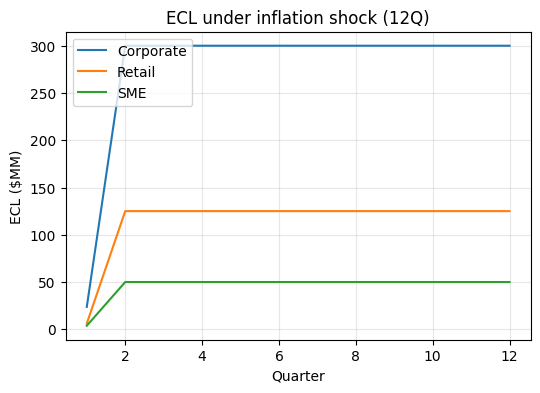

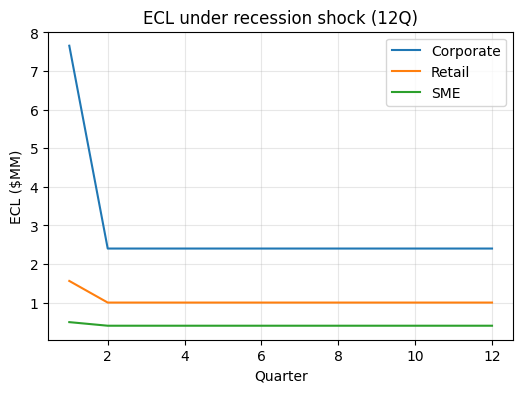

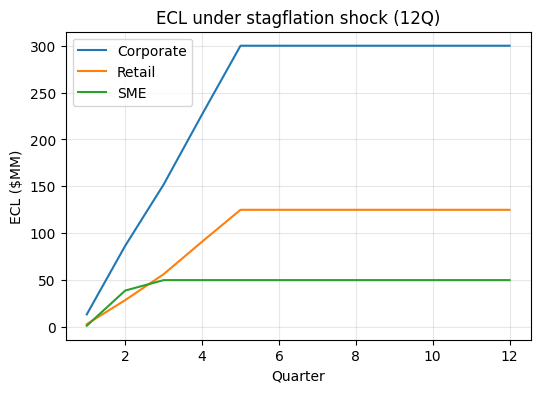

In [58]:
	# ---- Build scenario vectors from IRFs (length = 12 quarters) ----
	
k = 3.0  # stress scaler (same as your R `* 3`)
inflation_path  = resp_gdp_from_cpi_level * k     # GDP response to a CPI shock
recession_path  = resp_cpi_from_gdp_level * k     # CPI response to a GDP shock
stagflation_path = 0.5*(inflation_path + recession_path)
	
scenarios = {
	    "inflation":   inflation_path,
	    "recession":   recession_path,
	    "stagflation": stagflation_path
	}
	
	# ---- Stylized portfolio ----
portfolio = pd.DataFrame({
	    "Segment":  ["Retail", "SME", "Corporate"],
	    "Exposure": [1e9, 5e8, 2e9],
	    "PD_Base":  [0.02, 0.04, 0.03],
	    "LGD":      [0.50, 0.40, 0.60]
	})
	
	# Elasticities: %ΔPD per 1pp Δmacro (your calibration knobs)
elasticity = {"Retail": -0.12, "SME": -0.18, "Corporate": -0.10}
	
def pd_multiplier(irf_val, seg):
	    # IRF is in log units; multiplied by 100 to treat it like "pp".
	    # Keep the same mapping for parity:
	    return np.exp(elasticity[seg] * irf_val * 100)
	
pd_floor, pd_cap = 0.002, 0.25
	
	# ---- Expand to quarter-by-quarter ECLs ----
rows = []
for scn, path in scenarios.items():
	for q, macro_impulse in enumerate(path, start=1):
	    for _, r in portfolio.iterrows():
	        mult = pd_multiplier(macro_impulse, r.Segment)
	        pd_stress = np.clip(r.PD_Base * mult, pd_floor, pd_cap)
	        ecl = r.Exposure * pd_stress * r.LGD / 1e6  # $MM
	        rows.append((scn, q, r.Segment, pd_stress, ecl))
	
ecl_df = pd.DataFrame(rows, columns=["Scenario","Quarter","Segment","PD_Stress","ECL_MM"])
	
	# ---- Visuals ----
for scn, sub in ecl_df.groupby("Scenario"):
	    fig, ax = plt.subplots(figsize=(6,4))
	    for seg, segdf in sub.groupby("Segment"):
	        ax.plot(segdf["Quarter"], segdf["ECL_MM"], label=seg)
	    ax.set_title(f"ECL under {scn} shock (12Q)")
	    ax.set_xlabel("Quarter"); ax.set_ylabel("ECL ($MM)")
	    ax.legend(); ax.grid(True, alpha=0.3)
	    plt.show()
	


## Interpretations: ECL Paths

Prolonged inflation risk and transient growth shocks

Inflation scenario: 
+ Quarter 1–2: Inflation shock immediately raises credit losses — rapid translation of price pressure into margin compression and higher interest costs. Losses plateau almost instantly, showing limited persistence — the VAR in differences implies that the real economy absorbs price shocks quickly.
+ ECL now rises more steadily rather than jumping immediately — slow-burn inflation stress.
+ Corporate segment dominates in dollar terms. Retail and SME exposures scale proportionally with their elasticities but remain stable once the inflation shock is internalized.

Recession scenario:
+ GDP shocks mean-revert faster, reflected in ECL peaking early (by ~Q2–Q3) then fading.

Stagflation: 
+ Quarter 1–5: Combined inflation pressure and growth weakness amplify losses across all portfolios.

+ Inflation channel adds cost-push pressure, while GDP drag reduces revenue — joint effect peaks around Q5–Q6. Quarter 6–12: Normalization phase — GDP recovers faster, CPI lingers slightly, causing a gradual decline in losses.
    + The interaction of persistent inflation and transitory GDP weakness generates a bell-shaped ECL profile.  
    

## Forecasting

In [61]:
macro_levels.index

DatetimeIndex(['1947-01-01', '1947-04-01', '1947-07-01', '1947-10-01',
               '1948-01-01', '1948-04-01', '1948-07-01', '1948-10-01',
               '1949-01-01', '1949-04-01',
               ...
               '2023-01-01', '2023-04-01', '2023-07-01', '2023-10-01',
               '2024-01-01', '2024-04-01', '2024-07-01', '2024-10-01',
               '2025-01-01', '2025-04-01'],
              dtype='datetime64[ns]', length=314, freq='QS-OCT')

In [64]:
df_forecast.index

PeriodIndex(['2025Q3', '2025Q4', '2026Q1', '2026Q2', '2026Q3', '2026Q4',
             '2027Q1', '2027Q2', '2027Q3', '2027Q4', '2028Q1', '2028Q2'],
            dtype='period[Q-DEC]')

In [ ]:

n_ahead = 12

# --- use the fitted VAR on differences (var_diff) ---
lag_order = var_diff.k_ar
fc_diff = var_diff.forecast(y=macro_diff.values[-lag_order:], steps=n_ahead)   # (n_ahead, neqs)



# DataFrame of forecasted diffs: columns like "gdp_g", "cpi_g"
df_fc_diff = pd.DataFrame(fc_diff, index=forecast_index, columns=macro_diff.columns)

# cumulative sum to get forecasted log-level increments, then add last observed log-level
cum_log_incr = df_fc_diff.cumsum()

# Map last observed logs into the same order as macro_diff columns explicitly
#last_log_map = {name.replace("gdp","log_gdp").replace("cpi","log_cpi")[4:]: None}
# safer: build array by mapping each macro_diff column back to macro_levels
#last_logs_for_diff = np.array([macro_levels[f"log_{c.replace('_g','')}"][-1] for c in macro_diff.columns])

# Build last_logs in the same order as macro_diff.columns
last_logs = macro_levels[[f"log_{c.replace('_g','')}" for c in macro_diff.columns]].iloc[-1].values
# sanity check
assert last_logs.shape[0] == len(macro_diff.columns)

#replaced this -> last_logs = macro_levels.iloc[-1][['log_gdp', 'log_cpi']].values  # order matches macro_diff columns -> gdp_g, cpi_g
log_level_forecasts = cum_log_incr.values + last_logs[np.newaxis, :]

freq = macro_levels.index.freq or pd.offsets.QuarterBegin(startingMonth=10)
forecast_index = pd.date_range(start=macro_levels.index[-1] + freq, periods=n_ahead, freq=freq)

# tidy forecast DataFrame: columns "log_gdp_fc", "log_cpi_fc"
df_forecast = pd.DataFrame(log_level_forecasts, index=forecast_index,
                           columns=[f"log_{c.replace('_g','')}_fc" for c in macro_diff.columns])




In [66]:
df_combined = pd.concat([macro_levels, df_forecast], axis=0)

# back-transform for plotting
df_combined["GDP_forecast"] = np.exp(df_combined["log_gdp_fc"])
df_combined["CPI_forecast"] = np.exp(df_combined["log_cpi_fc"])

print(df_forecast.head())

            log_gdp_fc  log_cpi_fc
2025-07-01   10.083533    5.779965
2025-10-01   10.092161    5.786478
2026-01-01   10.100231    5.793359
2026-04-01   10.108480    5.800549
2026-07-01   10.116610    5.807805


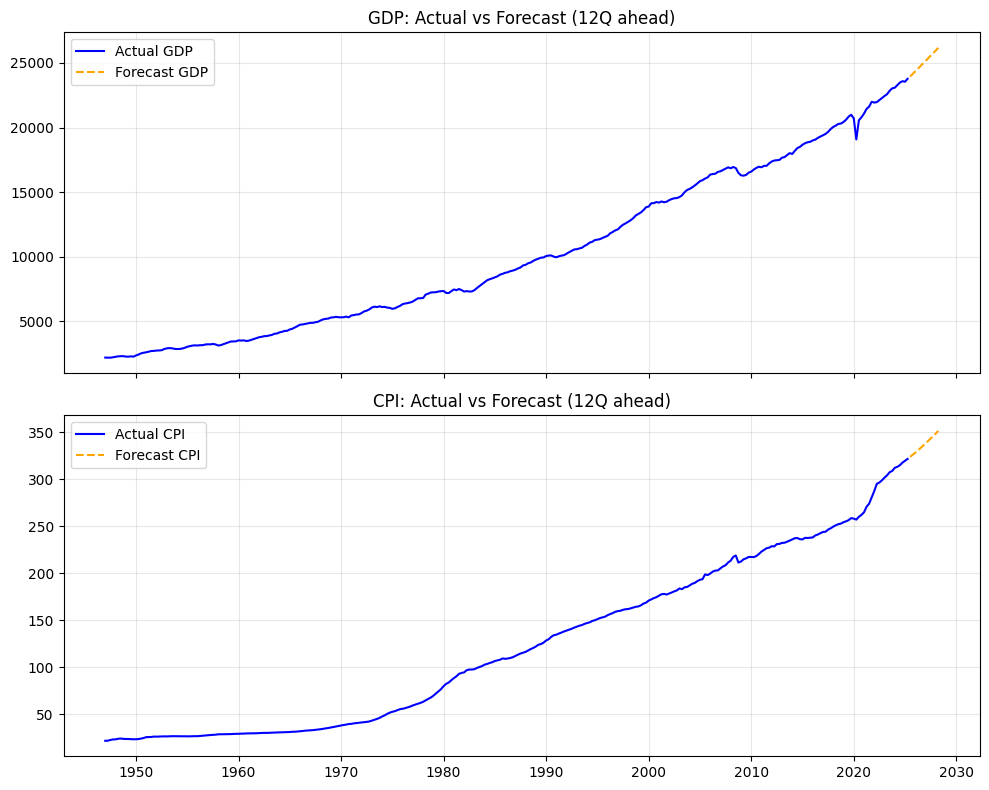

In [67]:

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# GDP actual vs forecast
axes[0].plot(np.exp(macro_levels["log_gdp"]), label="Actual GDP", color="blue")
axes[0].plot(df_combined["GDP_forecast"], label="Forecast GDP", color="orange", linestyle="--")
axes[0].set_title("GDP: Actual vs Forecast (12Q ahead)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cp actual vs forecast
axes[1].plot(np.exp(macro_levels["log_cpi"]), label="Actual CPI", color="blue")
axes[1].plot(df_combined["CPI_forecast"], label="Forecast CPI", color="orange", linestyle="--")
axes[1].set_title("CPI: Actual vs Forecast (12Q ahead)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## IRF plots

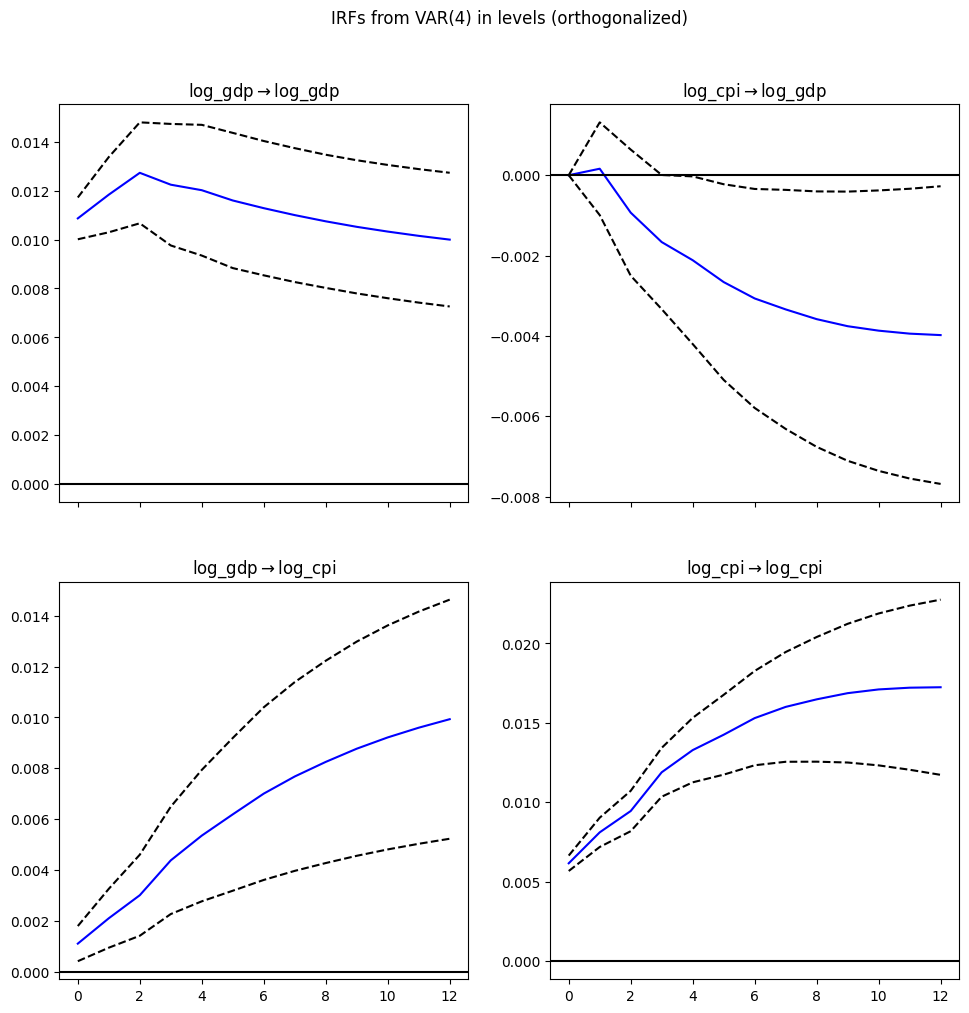

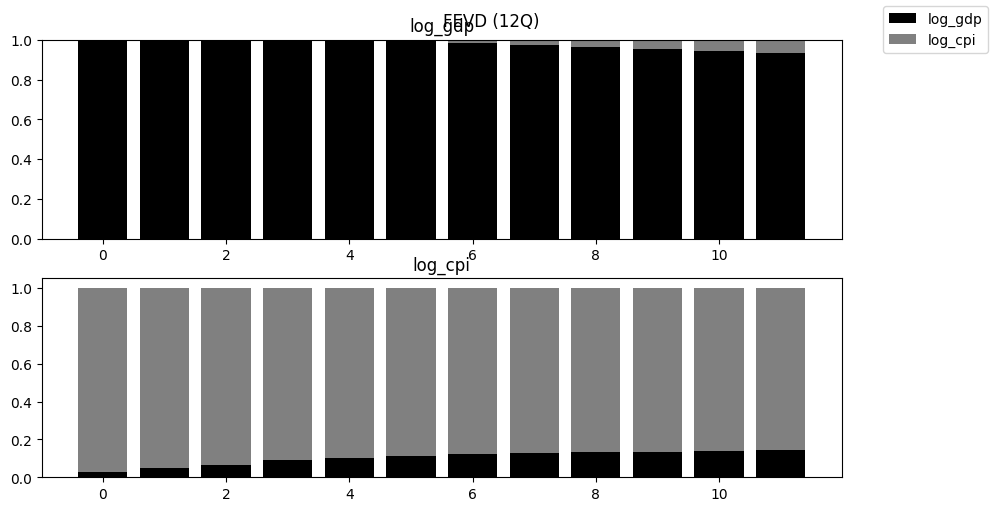

In [59]:
# IRF plots directly from statsmodels
fig = irf_cpi.plot(orth=True)   # full IRF grid
plt.suptitle("IRFs from VAR(4) in levels (orthogonalized)", y=1.02)
plt.show()

# FEVD bar/line for GDP at horizon 12
fig = fevd.plot(figsize=(10,5))
plt.suptitle("FEVD (12Q)")
plt.show()


## Interpretations: IRFs and FEVDs

The impulse responses and variance decompositions together characterize the macro transmission mechanics underlying this VAR(4) model.
Positive GDP shocks are persistent but gradually mean-reverting, consistent with cyclical momentum that dissipates over time.


+ GDP → CPI: Growth shocks raise inflation steadily for several quarters — an expansionary phase consistent with demand-driven inflation.


+ CPI → GDP: Inflation shocks exert a short-run drag on growth, fading by about the sixth quarter as monetary and real adjustments restore equilibrium.


+ CPI → CPI: Inflation inertia remains strong, though the effect plateaus beyond 8–10 quarters.


From the FEVD analysis, GDP’s uncertainty is primarily self-explained, while CPI’s variance shows moderate dependence on GDP shocks, confirming limited but meaningful spillovers from real activity to price dynamics.
For scenario design, this implies:
+ Inflation scenarios should propagate slowly and persist over several quarters.


+ Recession scenarios should exhibit sharper but shorter-lived GDP adjustments.


+ Stagflation scenarios can be built by combining these responses — prolonged inflation pressure coexisting with transitory growth weakness.
